# Generative Adversarial Network


## Imports

In [1]:
!pip3 install wandb tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 38.6 MB/s 
     |████████████████████████████████| 1.1 MB 52.5 MB/s 
     |████████████████████████████████| 182 kB 84.4 MB/s 
     |████████████████████████████████| 162 kB 88.1 MB/s 
     |████████████████████████████████| 63 kB 2.0 MB/s 
     |████████████████████████████████| 162 kB 72.1 MB/s 
     |████████████████████████████████| 158 kB 72.0 MB/s 
     |████████████████████████████████| 157 kB 75.7 MB/s 
     |████████████████████████████████| 157 kB 69.5 MB/s 
     |████████████████████████████████| 157 kB 96.3 MB/s 
     |████████████████████████████████| 157 kB 79.8 MB/s 
     |████████████████████████████████| 157 kB 92.4 MB/s 
     |████████████████████████████████| 157 kB 63.9 MB/s 
     |████████████████████████████████| 157 kB 97.6 MB/s 
     |████████████████████████████████| 156 kB 62.2 MB/s 
  Created wheel for pathtools: fi

In [1]:
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow import keras
from wandb.keras import WandbCallback

import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import wandb
import math

/Users/martin/miniforge3/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.7.0 and strictly below 2.10.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Utils

In [3]:
def show_results(model):
    random_latent_vectors = tf.random.normal(shape=(64, model.latent_dim))
    int_reward, generated_images = model(random_latent_vectors, training=False)

    plt.figure(figsize=(16, 24))
    for i in range(generated_images.shape[0]):
        plt.subplot(8, 8, i+1)
        plt.imshow(tf.cast((generated_images[i] * 127.5) + 127.5, tf.uint8))
        plt.title(f"Reward:\n{int_reward[i]}")
        plt.axis('off')
    plt.show()

## Model

In [5]:
class SelfAttnConv2D(keras.layers.Layer):
    def __init__(self, out_dim):
        super(SelfAttnConv2D, self).__init__()
        
        self.query_conv = keras.layers.Conv2D((out_dim // 8), 1)
        self.key_conv = keras.layers.Conv2D((out_dim // 8), 1)
        self.value_conv = keras.layers.Conv2D(out_dim, 1)

        self.gamma = tf.Variable(tf.zeros(1))
    
    def hw_flatten(self, x):
        return tf.reshape(x, shape=[x.shape[0], -1, x.shape[-1]])

    def call(self, inputs):
        # N = h * w
        energy = tf.matmul(self.hw_flatten(self.query_conv(inputs)), self.hw_flatten(self.key_conv(inputs)), transpose_b=True) # # [bs, N, N]
        attention = tf.nn.softmax(energy)
        out = tf.matmul(attention, self.hw_flatten(self.value_conv(inputs)))
        out = tf.reshape(out, shape=inputs.shape)

        return self.gamma * out + inputs

l = SelfAttnConv2D(64)
l(tf.random.normal([1, 4, 4, 64]))

<tf.Tensor: shape=(1, 4, 4, 64), dtype=float32, numpy=
array([[[[-1.3544159 ,  0.7045493 ,  0.03666191, ..., -0.5445253 ,
           1.5222509 ,  0.593032  ],
         [-0.63509274,  0.3703566 , -1.0939722 , ..., -1.865369  ,
           0.00511216, -1.0493753 ],
         [ 0.7901182 ,  1.585549  ,  0.43562782, ..., -0.63556796,
          -0.61617357, -1.9441465 ],
         [-0.48293006, -0.5244748 , -1.0345329 , ...,  1.3212337 ,
           0.345848  , -0.66993284]],

        [[ 0.46042565,  0.51493293, -0.06519881, ...,  1.2053189 ,
          -0.35114336,  0.13897078],
         [ 0.32744756, -0.3579723 ,  1.230323  , ..., -0.62931514,
           1.177553  ,  0.49572596],
         [-0.02589318,  1.1928992 ,  1.7263641 , ...,  0.63947624,
           1.4985783 , -1.0064989 ],
         [-1.831529  ,  0.4566331 , -0.49801955, ...,  0.48826355,
          -1.8867823 ,  0.18151632]],

        [[ 0.24483994,  0.37554735,  1.6184237 , ..., -1.915971  ,
           0.77674466,  0.7285135 ],
     

In [4]:
class GAN(keras.Model):
    def __init__(self, latent_dim):
        super(GAN, self).__init__()
        self.latent_dim = latent_dim

        # Create the discriminator
        self.discriminator = keras.Sequential(
            [
                keras.Input(shape=(64, 64, 3)),
                keras.layers.GaussianNoise(0.1),

                tfa.layers.SpectralNormalization(keras.layers.Conv2D(64, 3, strides=(1, 1), padding="same", kernel_initializer=TruncatedNormal(stddev=0.02))),
                keras.layers.LeakyReLU(alpha=0.1),
                tfa.layers.SpectralNormalization(keras.layers.Conv2D(64, 4, strides=(2, 2), padding="same", kernel_initializer=TruncatedNormal(stddev=0.02))),
                keras.layers.LeakyReLU(alpha=0.1),

                tfa.layers.SpectralNormalization(keras.layers.Conv2D(128, 3, strides=(1, 1), padding="same", kernel_initializer=TruncatedNormal(stddev=0.02))),
                keras.layers.LeakyReLU(alpha=0.1),
                tfa.layers.SpectralNormalization(keras.layers.Conv2D(128, 4, strides=(2, 2), padding="same", kernel_initializer=TruncatedNormal(stddev=0.02))),
                keras.layers.LeakyReLU(alpha=0.1),

                tfa.layers.SpectralNormalization(keras.layers.Conv2D(256, 3, strides=(1, 1), padding="same", kernel_initializer=TruncatedNormal(stddev=0.02))),
                keras.layers.LeakyReLU(alpha=0.1),
                tfa.layers.SpectralNormalization(keras.layers.Conv2D(256, 4, strides=(2, 2), padding="same", kernel_initializer=TruncatedNormal(stddev=0.02))),
                keras.layers.LeakyReLU(alpha=0.1),

                tfa.layers.SpectralNormalization(keras.layers.Conv2D(512, 4, strides=(2, 2), padding="same", kernel_initializer=TruncatedNormal(stddev=0.02))),
                keras.layers.LeakyReLU(alpha=0.1),

                keras.layers.Conv2D(1, 4, kernel_initializer=TruncatedNormal(stddev=0.02)),
                keras.layers.Flatten()
            ],
            name="discriminator",
        )
        self.generator = keras.Sequential(
            [
                keras.Input(shape=(latent_dim,)),
                keras.layers.Reshape((1, 1, latent_dim)),

                keras.layers.Conv2DTranspose(512, 4, use_bias=False, kernel_initializer=TruncatedNormal(stddev=0.02)),
                tfa.layers.InstanceNormalization(),
                keras.layers.LeakyReLU(alpha=0.1),

                keras.layers.Conv2DTranspose(256, 4, strides=(2, 2), padding="same", use_bias=False, kernel_initializer=TruncatedNormal(stddev=0.02)),
                tfa.layers.InstanceNormalization(),
                keras.layers.LeakyReLU(alpha=0.1),

                keras.layers.Conv2DTranspose(128, 4, strides=(2, 2), padding="same", use_bias=False, kernel_initializer=TruncatedNormal(stddev=0.02)),
                tfa.layers.InstanceNormalization(),
                keras.layers.LeakyReLU(alpha=0.1),

                keras.layers.Conv2DTranspose(64, 4, strides=(2, 2), padding="same", use_bias=False, kernel_initializer=TruncatedNormal(stddev=0.02)),
                tfa.layers.InstanceNormalization(),
                keras.layers.LeakyReLU(alpha=0.1),

                keras.layers.Conv2DTranspose(3, 4, strides=(2, 2), padding="same", activation='tanh', kernel_initializer=TruncatedNormal(stddev=0.02)),
            ],
            name="generator",
        )

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def call(self, inputs, training=None):
        generated_images = self.generator(inputs, training=training)
        score = self.discriminator(generated_images, training=training)
        return score, generated_images

    def summary(self):
        self.generator.summary()
        self.discriminator.summary()

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]

        # -------------------- Update 'Discriminator' -------------------- #
        with tf.GradientTape() as tape:
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

            fake_output, _ = self(random_latent_vectors, training=True)
            real_output = self.discriminator(real_images, training=True)

            d_loss_real = self.loss_fn(tf.ones_like(real_output), real_output)
            d_loss_fake = self.loss_fn(tf.ones_like(fake_output)*(-1), fake_output)
            d_loss = d_loss_real + d_loss_fake

        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # -------------------- Update 'Generator' -------------------- #
        with tf.GradientTape() as tape:
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            fake_output, _ = self(random_latent_vectors, training=True)
            g_loss = - tf.reduce_mean(fake_output)

        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        return {
            "d_loss": d_loss,
            "g_loss": g_loss,
            "real_output": tf.reduce_mean(real_output),
            "fake_output": tf.reduce_mean(fake_output),
        }

## Dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dataset_loaded = tfds.load('celeb_a', shuffle_files=True, download=True, data_dir='/content/drive/MyDrive/tensorflow_datasets')
dataset = dataset_loaded['train'].concatenate(dataset_loaded['test'])
dataset = dataset.concatenate(dataset_loaded['validation'])

dataset = dataset.map(lambda data: tf.image.resize(data['image'], [64, 64]), num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.map(lambda img: (tf.cast(img, tf.float32) - 127.5) / 127.5, num_parallel_calls=tf.data.AUTOTUNE)  # Normalize the images to [-1, 1]
dataset = dataset.shuffle(buffer_size=100000, reshuffle_each_iteration=True).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

## Training

In [ ]:
wandb.init(project="GAN")

In [ ]:
gan = GAN(latent_dim=128)
gan.compile(
    d_optimizer=keras.optimizers.Adam(
        learning_rate=0.0002,
        beta_1=0.5,
        beta_2=0.999,
    ),
    g_optimizer=keras.optimizers.Adam(
        learning_rate=0.0002,
        beta_1=0.5,
        beta_2=0.999,
    ),
    loss_fn=keras.losses.Hinge(),
)
gan.summary()
show_results(gan)

In [ ]:
gan.fit(
    dataset,
    epochs=316,
    callbacks=[
        WandbCallback(monitor='g_loss', mode='min', save_model=False),
    ],
)

In [ ]:
gan.save_weights("/content/drive/MyDrive/weights_GAN.h5")
wandb.save("/content/drive/MyDrive/weights_GAN.h5")

## Evaluation

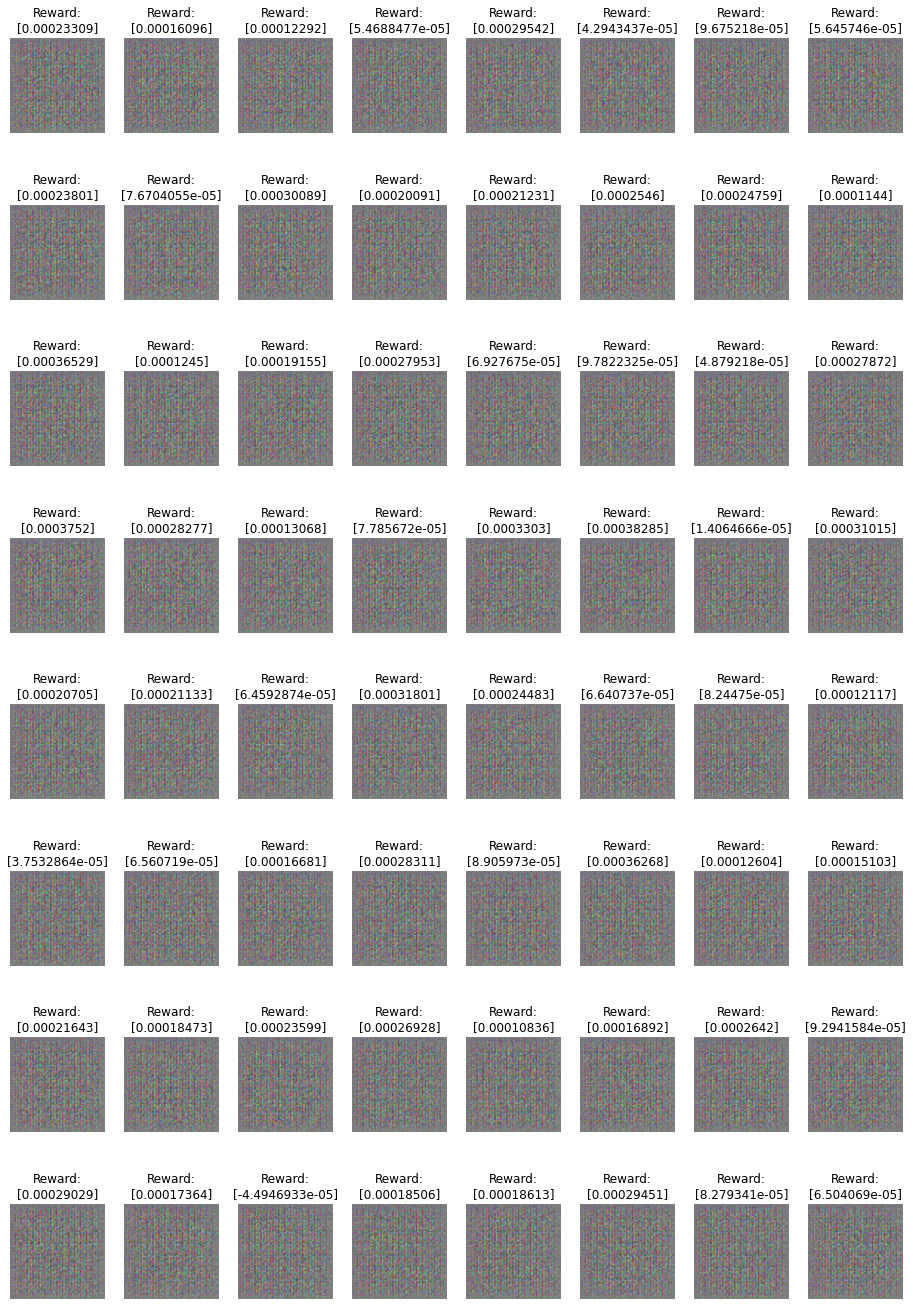

In [7]:
gan = GAN(latent_dim = 128)
show_results(gan)
gan.load_weights("/content/drive/MyDrive/weights_GAN.h5")

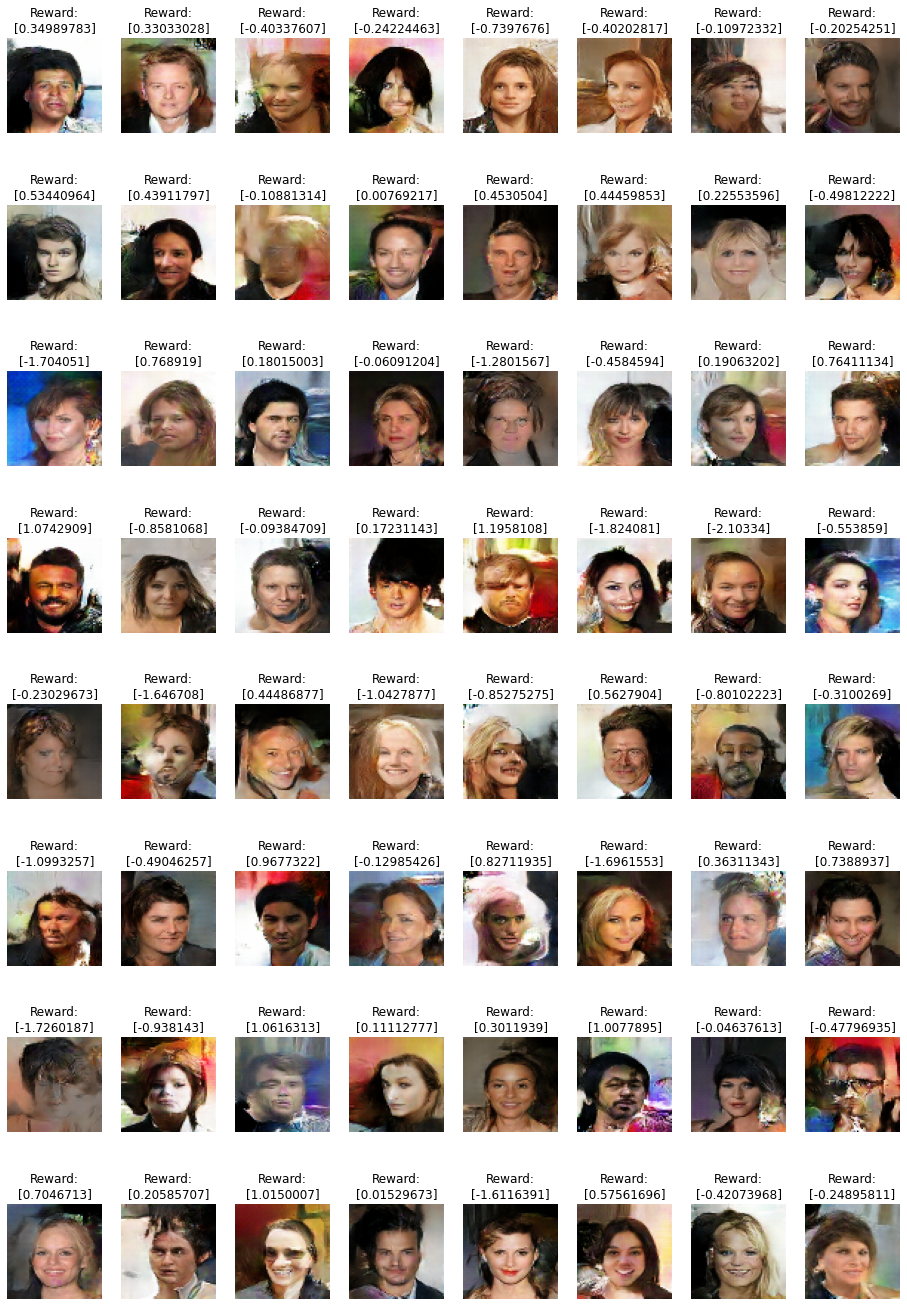

In [10]:
show_results(gan)

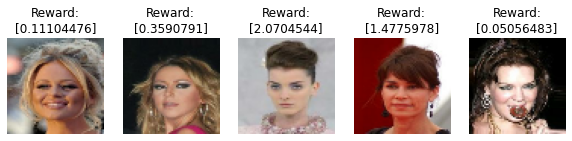

In [9]:
real_image = list(dataset.take(1).as_numpy_iterator())[0]
int_reward = gan.discriminator(real_image[:5], training=False)

plt.figure(figsize=(10, 15))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(tf.cast((real_image[i] * 127.5) + 127.5, tf.uint8))
    plt.title(f"Reward:\n{int_reward[i]}")
    plt.axis('off')
plt.show()